In [1]:
import pandas as pd
import numpy as np

import re
import pdb

In [57]:
import dask
dask.config.set(scheduler="processes")

@dask.delayed
def load_TRTH_trade(filename,
             tz_exchange="America/New_York",
             only_non_special_trades=True,
             only_regular_trading_hours=True,
             open_time="09:30:00",
             close_time="16:00:00",
             merge_sub_trades=True):
    try:
        if re.search('(csv|csv\\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search('parquet$',filename):
            DF = pd.read_parquet(filename)

    except Exception as e:
     #   print("load_TRTH_trade could not load "+filename)
     #   print(e)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    
    if DF.shape[0]==0:
        return None
    
    if only_non_special_trades:
        DF = DF[DF["trade-stringflag"]=="uncategorized"]

    DF.drop(columns=["trade-rawflag","trade-stringflag"],axis=1,inplace=True)
    
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time,close_time)    # warning: ever heard e.g. about Thanksgivings?
    
    if merge_sub_trades:
           DF=DF.groupby(DF.index).agg(trade_price=pd.NamedAgg(column='trade-price', aggfunc='mean'),
                                       trade_volume=pd.NamedAgg(column='trade-volume', aggfunc='sum'))
    
    return DF



#@dask.delayed
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             only_regular_trading_hours=True,
             merge_sub_trades=True):
    try:
        if re.search(r'(csv|csv\.gz)$',filename):
            DF = pd.read_csv(filename)
        if re.search(r'arrow$',filename):
            DF = pd.read_arrow(filename)
        if re.search(r'parquet$',filename):
            DF = pd.read_parquet(filename) 
    except Exception as e:
       # print("load_TRTH_bbo could not load "+filename)
        return None
    
    try:
        DF.shape
    except Exception as e: # DF does not exist
        print("DF does not exist")
        print(e)
        return None

    if DF.shape[0]==0:
        return None
    
        
    DF.index = pd.to_datetime(DF["xltime"],unit="d",origin="1899-12-30",utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    DF.drop(columns="xltime",inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time("09:30:00","16:00:00")    # ever heard about Thanksgivings?
        
    if merge_sub_trades:
        DF=DF.groupby(DF.index).last()
    

        
    return DF

In [57]:
bbo   = load_TRTH_bbo("data/raw/TRTH/equities/US/bbo/SPY.P/2017-01-03-SPY.P-bbo.parquet")

In [21]:
mid=(bbo["ask-price"]+bbo["bid-price"])/2

In [3]:
%time events=pd.read_parquet("SPY_2009_events.parquet")

CPU times: user 24.5 s, sys: 8.99 s, total: 33.5 s
Wall time: 10.9 s


In [4]:
events.ffill(inplace=True)

In [5]:
mid=(events["ask-price"]+events["bid-price"])*0.5



In [22]:
mid

xltime
2017-01-03 09:30:00.074000384-05:00    225.035
2017-01-03 09:30:00.682000384-05:00    225.055
2017-01-03 09:30:00.773000192-05:00    225.055
2017-01-03 09:30:00.773000192-05:00    225.065
2017-01-03 09:30:00.773000192-05:00    225.070
                                        ...   
2017-01-03 15:59:59.991000320-05:00    225.175
2017-01-03 15:59:59.991000320-05:00    225.175
2017-01-03 15:59:59.994000128-05:00    225.175
2017-01-03 15:59:59.994000128-05:00    225.175
2017-01-03 15:59:59.994000128-05:00    225.175
Length: 961046, dtype: float64

In [28]:
signature=[]
ks=range(1,30,1)
for dt in range(1,100):
    resample_freq = str(k)+"S"
    logrets=mid.resample(resample_freq).last().diff().values
    logrets=logrets[logrets!=0]
    signature.append(np.nanmean(logrets*logrets)/dt)

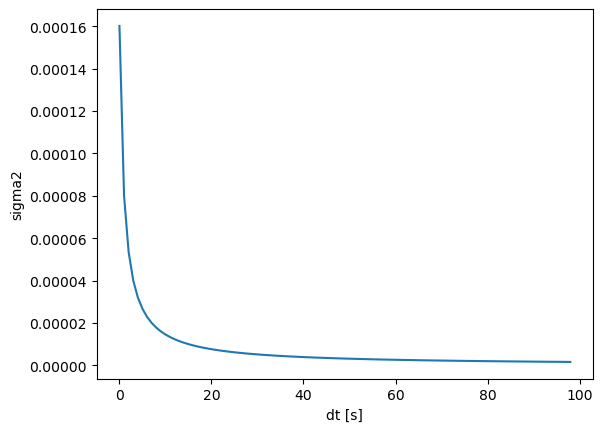

In [29]:
import matplotlib.pyplot as plt
plt.plot(signature)
plt.ylabel("sigma2")
plt.xlabel("dt [s]")
plt.show()


### Activity plot

In [ ]:
events["mid-price"]=(events["ask-price"]+events["bid-price"])*.5
events["spread_relative"]=(events["ask-price"]-events["bid-price"])

In [ ]:
%%time
events["seconds"]=events.index.hour*3600+events.index.minute*60+events.index.second
events["5m"]=(events["seconds"].values // (5*60))*(5*60)/3600   # chunks of 5 minutes, then convert into hours

In [ ]:
avg_spread=events[["5m","spread_relative"]].groupby("5m").mean()

In [ ]:
%%time
avg_spread=events["spread_relative"].groupby(events.index.floor('5T').time).mean()

In [ ]:
avg_spread.plot()
plt.ylabel("average spread")
plt.xlabel("hour")

plt.show()

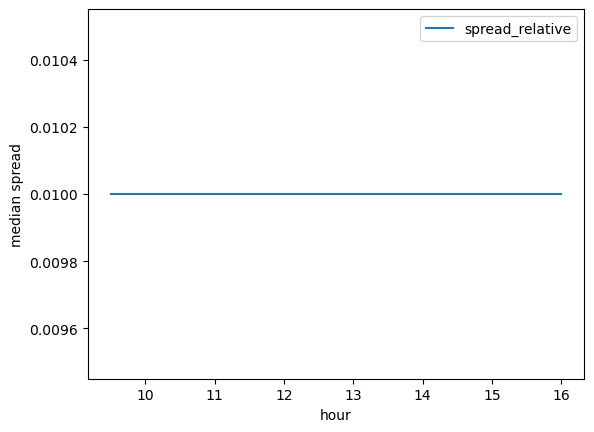

In [47]:
# spread is minimal for SPY.P

median_spread=events[["5m","spread_relative"]].groupby("5m").median()
median_spread.plot()
plt.ylabel("median spread")
plt.xlabel("hour")

plt.show()

In [59]:
## Number of trades
import glob

allfiles=glob.glob("data/raw/TRTH/equities/US/trade/SPY.P/2010*parquet")
allfiles.sort()

allpromises=[load_TRTH_trade(myfile) for myfile in allfiles]
trades=pd.concat(dask.compute(allpromises)[0])

In [60]:
trades["seconds"]=trades.index.hour*3600+trades.index.minute*60+trades.index.second
trades["5m"]=(trades["seconds"].values // (5*60))*(5*60)/3600   # chunks of 5 minutes, then convert into hours

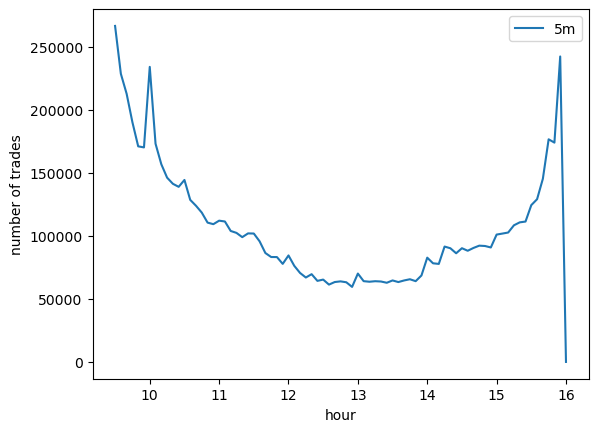

In [61]:
trades_per_5m=pd.DataFrame(trades["5m"].value_counts())
trades_per_5m.sort_index().plot()
plt.ylabel("number of trades")
plt.xlabel("hour")
plt.show()

## Volume

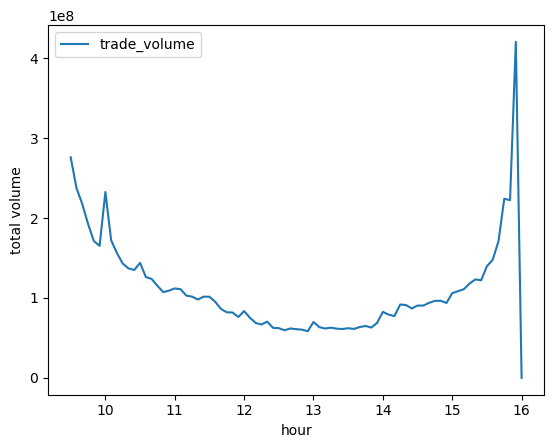

In [62]:
tradevolume_per_5m=pd.DataFrame(trades[["5m","trade_volume"]].groupby("5m").sum())


tradevolume_per_5m.sort_index().plot()
plt.ylabel("total volume")
plt.xlabel("hour")
plt.show()

## Time between transactions

In [64]:
import datetime


trades["dt_trans"]=np.append(0,np.diff(trades.index)/datetime.timedelta(seconds=1))

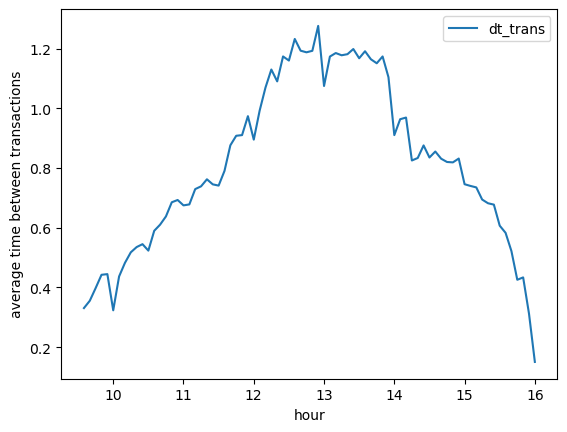

In [65]:
dt_avg=pd.DataFrame(trades[["5m","dt_trans"]].groupby("5m").mean())
dt_avg.drop(index=dt_avg.index[0],axis=0,inplace=True)   # drop the first line

dt_avg.plot()
plt.ylabel("average time between transactions")
plt.xlabel("hour")
plt.show()

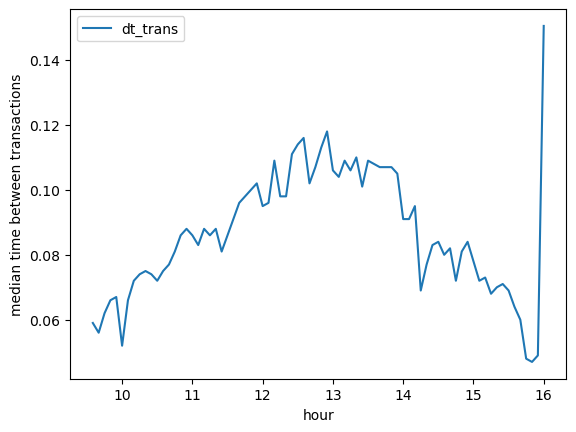

In [66]:
dt_med=pd.DataFrame(trades[["5m","dt_trans"]].groupby("5m").median())
dt_med.drop(index=dt_med.index[0],axis=0,inplace=True)   # drop the first line

dt_med.plot()
plt.ylabel("median time between transactions")
plt.xlabel("hour")
plt.show()

The median is much smaller than the average: this is because the distribution of the time between two transactions is heavy tailed.